<a href="https://colab.research.google.com/github/BiancaRotaruAlexandra/CursML/blob/main/Proiect_Predictia_Calitatii_Vinului.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicția calității vinului

Obiectiv: pe baza analizelor din fișierul CSV, construim un model de Machine Learning care prezice calitatea acordată de un panel de experți (scor 0–10)

În notebook:
- încărcăm și descriem datele
- construim un model (alegerea: Random Forest)
- evaluăm cu accuracy, confusion matrix
- explicăm rezultatele, propunem îmbunătățiri


In [8]:
import pandas as pd
import numpy as np

url = "https://raw.githubusercontent.com/shrikant-temburwar/Wine-Quality-Dataset/master/winequality-red.csv"

# GitHub raw folosește separator ';'
df = pd.read_csv(url, sep=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## 1) Cum arată dataset-ul (variabile, tipuri, observații)

- Observații (rânduri): fiecare rând = un lot de vin
- Variabile (coloane): indicatori chimici măsurați în laborator (aciditate, pH, alcool, sulfați etc.) + `quality`
- Majoritatea variabilelor sunt numerice (float). `quality` este un scor întreg 0–10

Mai jos: dimensiune, tipuri de date, valori lipsă


In [9]:
df.shape, df.dtypes

((1599, 12),
 fixed acidity           float64
 volatile acidity        float64
 citric acid             float64
 residual sugar          float64
 chlorides               float64
 free sulfur dioxide     float64
 total sulfur dioxide    float64
 density                 float64
 pH                      float64
 sulphates               float64
 alcohol                 float64
 quality                   int64
 dtype: object)

In [10]:
df.isna().sum()

,0
fixed acidity,0
volatile acidity,0
citric acid,0
residual sugar,0
chlorides,0
free sulfur dioxide,0
total sulfur dioxide,0
density,0
pH,0
sulphates,0


### Distribuția țintei (`quality`) și clase neechilibrate

În mod tipic, scorurile se concentrează în jurul valorilor 5–6, iar scorurile mari (7–8) sunt mai rare.
Asta creează dezechilibru


In [11]:
df['quality'].value_counts().sort_index()

,count
quality,
3,10
4,53
5,681
6,638
7,199
8,18


### Transformarea țintei în clase

Agregăm scorul în 3 clase:
- low: ≤5 (loturi sub medie / risc de reclamații)
- medium: =6 (loturi OK / standard)
- high: ≥7 (loturi premium)

Avantaj: interpretare și decizii mai clare. Dezavantaj: pierdem din granularitate (ex. diferența dintre 7 și 8)


In [12]:
def bin_quality(q):
    if q <= 5:
        return "low (<=5)"
    if q == 6:
        return "medium (=6)"
    return "high (>=7)"

y = df['quality'].apply(bin_quality)
y.value_counts()

,count
quality,
low (<=5),744
medium (=6),638
high (>=7),217


## 2) Limitări ale datasetului

1) **Lipsesc variabile de context** care influențează calitatea percepută:
- soi/assemblage, regiune, an (vintage), tip de maturare/învechire, brand, preț, poziționare

2) **Calitatea este subiectivă** (panel de experți):
- scorul poate varia între evaluatori sau între sesiuni

3) **Clase neechilibrate**:
- loturile „high” sunt mai puține → modelul poate tinde să prezică clasele frecvente

4) **Generalizare limitată**:
- modelul învață relații din acest set; dacă apar vinuri din alt stil/altă gamă, performanța poate scădea


## 3) Modelul ales: Random Forest

Random Forest este potrivit pentru date tabulare și relații non-liniare:
- performanță bună „out of the box”
- robust la outlieri și nu cere obligatoriu standardizare
- oferă feature importance

În plus folosim `class_weight` ca să reducem efectul dezechilibrului de clase

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

X = df.drop(columns=['quality'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("rf", RandomForestClassifier(
        n_estimators=400,
        random_state=42,
        class_weight="balanced_subsample",
        n_jobs=-1
    ))
])

model.fit(X_train, y_train)

pred = model.predict(X_test)
acc = accuracy_score(y_test, pred)
acc

0.74375

## 4) Rezultate (accuracy, matrice de confuzie) și interpretare

### Accuracy
`accuracy` = proporția de loturi clasificate corect
Când clasele sunt neechilibrate, accuracy poate fi înșelător, deci vom analiza confusion matrix + precision/recall


In [14]:
print(f"Accuracy: {acc:.3f}")
print("Classification report:")
print(classification_report(y_test, pred, digits=3))

Accuracy: 0.744
Classification report:
              precision    recall  f1-score   support

  high (>=7)      0.676     0.581     0.625        43
   low (<=5)      0.794     0.826     0.809       149
 medium (=6)      0.703     0.703     0.703       128

    accuracy                          0.744       320
   macro avg      0.724     0.703     0.712       320
weighted avg      0.742     0.744     0.742       320



### Confusion Matrix

Arată ce tipuri de greșeli face modelul

Exemple de impact:
- high prezis ca medium - risc: lot premium vândut sub preț (pierdere de marjă)
- low prezis ca medium/high - risc: lot slab trimis în piață (reputație, reclamații)


<Figure size 600x500 with 0 Axes>

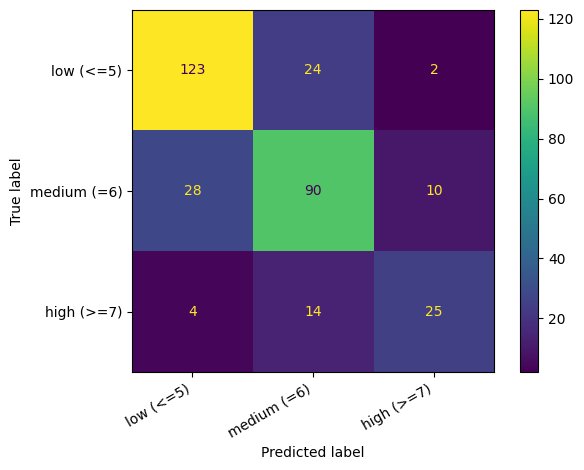

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

labels = ["low (<=5)", "medium (=6)", "high (>=7)"]
cm = confusion_matrix(y_test, pred, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
plt.figure(figsize=(6,5))
disp.plot(values_format='d')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

## 5) Interpretare: ce variabile contează

Feature importance e util pentru:
- insight-uri de QA (ce indicatori sunt cei mai „sensibili”)
- prioritizarea testelor sau a controalelor interne


In [16]:
import pandas as pd

rf_fitted = model.named_steps['rf']
importances = pd.Series(rf_fitted.feature_importances_, index=X.columns).sort_values(ascending=False)
importances.head(10)

,0
alcohol,0.166391
sulphates,0.115984
volatile acidity,0.111290
total sulfur dioxide,0.094282
citric acid,0.088340
density,0.082294
chlorides,0.076531
fixed acidity,0.072085
pH,0.067013
free sulfur dioxide,0.063637


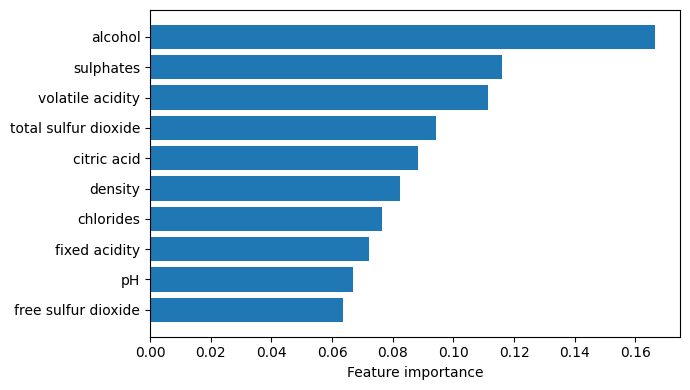

In [17]:
# Plot importanțe (top 10)
top = importances.head(10).sort_values()

plt.figure(figsize=(7,4))
plt.barh(top.index, top.values)
plt.xlabel('Feature importance')
plt.tight_layout()
plt.show()

### Ce înseamnă pentru cramă

Dacă `alcohol`, `sulphates`, `volatile acidity` ies ca fiind foarte importante:
- modelul sugerează că aceste variabile sunt puternic asociate cu percepția de calitate în setul de date
- poți folosi modelul ca screening: loturile cu probabilitate mare de low pot fi retestate / ajustate înainte de îmbuteliere


## 6) Cum aș îmbunătăți performanța

1) **Tuning de hiperparametri**
- Ajustarea parametrilor Random Forest (`max_depth`, `min_samples_leaf`, `max_features`, `n_estimators`)
- Scop: reducerea overfitting-ului și captarea mai bună a relațiilor dintre variabile

2) **Cross-validation**
- Evaluarea modelului pe mai multe split-uri de date
- Oferă o estimare mai stabilă și mai realistă a performanței în producție

3) **Gestionarea dezechilibrului de clase**
- Tehnici precum oversampling sau ajustarea ponderilor de clasă
- Îmbunătățirea recunoașterii loturilor rare, dar critice (ex. vinuri premium)

4) **Date suplimentare**
- Informații despre soi, regiune, an (vintage)
- Tipul de maturare / învechire
- Date operaționale: temperaturi de fermentație, timp de macerație
- Preț sau segment de piață
